In [1]:
# Analysis of survival data and numbers for each ovarian cohort with platinus response... 

# patients must undergo first line pltinum therapy only!
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

## Make each df with the WSIs avalable too in the df! then we can get final counts....
## Present for each cohort the dist and linical vars so e can decide ow to split etc ...

## PLCO - Ovarian

num overall patients 78209
cencership 0    54608
1    23601
Name: is_dead, dtype: int64
NaN    77617
1.0      468
0.0      124
Name: ovar_curative_chemo, dtype: int64
NaN     77393
2.0       416
0.0       203
1.0        89
3.0        87
11.0       19
10.0        2
Name: ovar_primary_trt, dtype: int64
BREAK
platinum treated cencership 1    372
0     96
Name: is_dead, dtype: int64
BREAK
468
cenreded nums 0


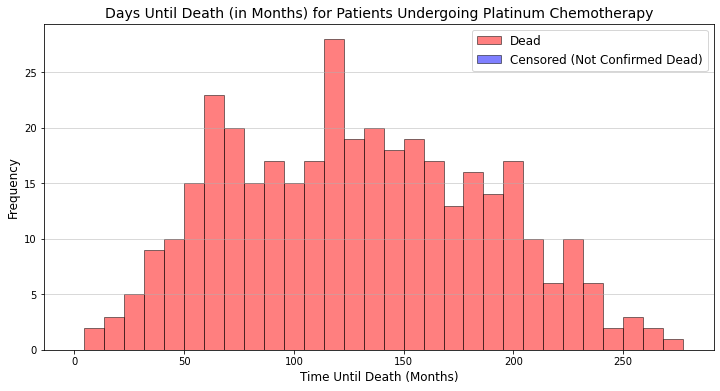

Number of patients:  372


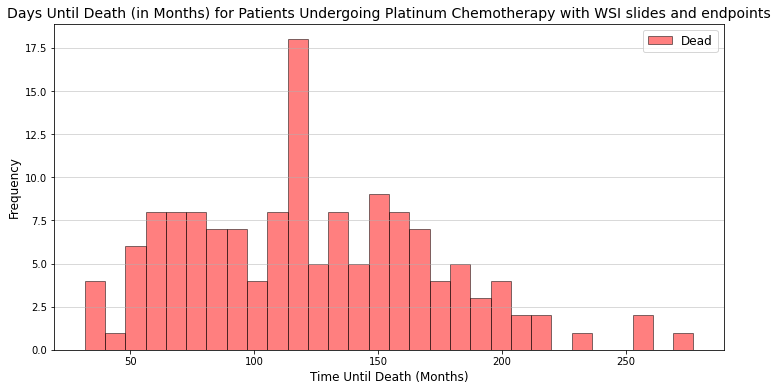

final cohort number 145


In [9]:
clinical = pd.read_csv("/tank/WSI_data/PLCO-NIH/package-plcoi-1720/Ovarian/ovar_data_mar22_d032222.csv")

print("num overall patients",len(clinical))

print("cencership",clinical['is_dead'].value_counts(dropna=False))




# TODO: importnat to see how we filter her and also check how many of these cases have WSIs too
print(clinical['ovar_curative_chemo'].value_counts(dropna=False))

print(clinical['ovar_primary_trt'].value_counts(dropna=False))





# Filter for patients who underwent platinum chemotherapy
platinum_chemo_patients = clinical[clinical['ovar_curative_chemo'] == 1]


print("BREAK")

print("platinum treated cencership",platinum_chemo_patients['is_dead'].value_counts(dropna=False))

print("BREAK")



print(len(platinum_chemo_patients))
# Drop rows with missing or non-numeric values in 'dth_days'
platinum_chemo_patients = platinum_chemo_patients[platinum_chemo_patients['dth_days'].notna()]
platinum_chemo_patients['dth_days'] = pd.to_numeric(platinum_chemo_patients['dth_days'], errors='coerce')

# Convert days to months
platinum_chemo_patients['dth_months'] = platinum_chemo_patients['dth_days'] / 30.44  # Approximate days per month

# Split data by censoring status (is_dead)
dead = platinum_chemo_patients[platinum_chemo_patients['is_dead'] == 1]
censored = platinum_chemo_patients[platinum_chemo_patients['is_dead'] != 1]

print("cenreded nums",len(censored)) #here there are no days to event at all...


# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(dead['dth_months'], bins=30, alpha=0.5, label='Dead', color='red', edgecolor='black')


plt.hist(censored['dth_months'], bins=30, alpha=0.5, label='Censored (Not Confirmed Dead)', color='blue', edgecolor='black')

# Add titles and labels
plt.title('Days Until Death (in Months) for Patients Undergoing Platinum Chemotherapy', fontsize=14)
plt.xlabel('Time Until Death (Months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.6)

# Show the plot
plt.show()

print("Number of patients: ", len(platinum_chemo_patients)) # get number of these with slides....?


# ovar_has_deliv_heslide_img

# ovar_num_heslide_imgs
# No its wrong ?  fit two gausins on this?.... need to descide how to select as chemo subset is much smaller.. 

platinum_chemo_patients['ovar_has_deliv_heslide_img'].value_counts(dropna=False) #145 only...


# Take only patients with slides 

platinum_chemo_patients = platinum_chemo_patients[platinum_chemo_patients['ovar_has_deliv_heslide_img'] == 1]


# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(platinum_chemo_patients['dth_months'], bins=30, alpha=0.5, label='Dead', color='red', edgecolor='black')


# Add titles and labels
plt.title('Days Until Death (in Months) for Patients Undergoing Platinum Chemotherapy with WSI slides and endpoints', fontsize=14)
plt.xlabel('Time Until Death (Months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.6)

# Show the plot
plt.show()

print("final cohort number",len(platinum_chemo_patients))

Gaussian 1: Amplitude=11.49, Mean=64.17, Sigma=7.94
Gaussian 2: Amplitude=20.24, Mean=132.46, Sigma=65.00


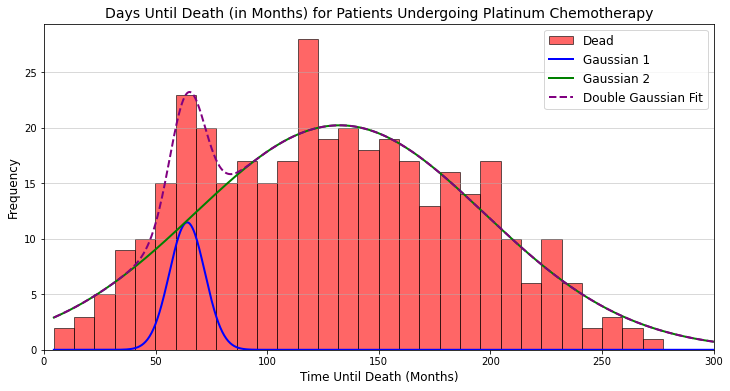

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data
clinical = pd.read_csv("/tank/WSI_data/PLCO-NIH/package-plcoi-1720/Ovarian/ovar_data_mar22_d032222.csv")

# Filter for patients who underwent platinum chemotherapy
platinum_chemo_patients = clinical[clinical['ovar_curative_chemo'] == 1]

# Drop rows with missing or non-numeric values in 'dth_days'
platinum_chemo_patients = platinum_chemo_patients[platinum_chemo_patients['dth_days'].notna()]
platinum_chemo_patients['dth_days'] = pd.to_numeric(platinum_chemo_patients['dth_days'], errors='coerce')

# Convert days to months
platinum_chemo_patients['dth_months'] = platinum_chemo_patients['dth_days'] / 30.44  # Approximate days per month

# Select data for deceased patients
dead = platinum_chemo_patients[platinum_chemo_patients['is_dead'] == 1]

# Define double Gaussian function
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)) +
            A2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)))

# Plot histogram
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(dead['dth_months'], bins=30, alpha=0.6, label='Dead', color='red', edgecolor='black')

# Calculate the centers of the bins
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Initial guesses for the parameters
initial_guess = [
    max(counts)/2, np.percentile(dead['dth_months'], 25), np.std(dead['dth_months'])/2,
    max(counts)/2, np.percentile(dead['dth_months'], 75), np.std(dead['dth_months'])/2
]

# Fit the double Gaussian
try:
    popt, pcov = curve_fit(double_gaussian, bin_centers, counts, p0=initial_guess)
except RuntimeError:
    print("Error - curve_fit failed")
    popt = initial_guess  # Fallback to initial guesses

# Extract parameters
A1, mu1, sigma1, A2, mu2, sigma2 = popt
print(f"Gaussian 1: Amplitude={A1:.2f}, Mean={mu1:.2f}, Sigma={sigma1:.2f}")
print(f"Gaussian 2: Amplitude={A2:.2f}, Mean={mu2:.2f}, Sigma={sigma2:.2f}")

# Generate x-values for plotting the Gaussians
x_fit = np.linspace(min(dead['dth_months']), 300, 1000)  # Set xmax to 300

# Compute the Gaussian curves
gaussian1 = A1 * np.exp(-((x_fit - mu1) ** 2) / (2 * sigma1 ** 2))
gaussian2 = A2 * np.exp(-((x_fit - mu2) ** 2) / (2 * sigma2 ** 2))
double_gaussian_fit = gaussian1 + gaussian2

# Plot the fitted Gaussians
plt.plot(x_fit, gaussian1, label='Gaussian 1', color='blue', linewidth=2)
plt.plot(x_fit, gaussian2, label='Gaussian 2', color='green', linewidth=2)
plt.plot(x_fit, double_gaussian_fit, label='Double Gaussian Fit', color='purple', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Days Until Death (in Months) for Patients Undergoing Platinum Chemotherapy', fontsize=14)
plt.xlabel('Time Until Death (Months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.6)
plt.xlim(0, 300)  # Set xmax to 300

# Show the plot
plt.show()


# PTCR-HGSOC

In [4]:
# Read DF of patients splits are by split definitons from epsone 
HGSOC = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/HGSOC_processed_data/PTRC-HGSOC_List_clincal_data.xlsx")
HGSOC.head()

HGSOC = HGSOC[HGSOC['Neo-adjuvant'] == 'no']

HGSOC['Tumor response'] = HGSOC['Tumor response'].str.lower()
HGSOC['Tumor response'].value_counts()

unique_patients = HGSOC['Patient ID'].nunique()
print(f"Number of unique patients: {unique_patients}")
# Neo-adjuvant # take non neroadrgevt paprtes! 

# Copy the definition here or response and non response ... 

# Treatment-naive tissue specimens from Stage III or IV HGSOCs that underwent primary debulking followed by platinum/taxane
# adjuvant therapy were selected for the study and categorized with respect to response to adjuvant chemotherapy, as defined below.
# (After the profiling was completed, we learned that a subset of 13 tumors had undergone neoadjuvant chemotherapy, and these are
# annotated in Table S1. These samples were not included in the construction and evaluation of the prediction model, and neoadjuvant
# status was included as a covariate in other analyses.)
# Refractory tumors were defined as follows: After primary debulking: for R0 disease (no residual/microscopic disease after primary
# resection), radiographically detectable disease must have been present at the end of 6 cycles of initial platinum/taxane therapy; for
# R1 disease (radiographically detectable residual disease is present after primary resection), residual disease must either progress or
# stay stable (radiographically) after 6 cycles of initial platinum/taxane therapy.
# Sensitive tumors were defined by R1 or R2 disease that received primary resection followed by platinum/taxane adjuvant therapy
# and had a progression-free survival of at least 2 years (no R0 disease).
# All biospecimens were collected with Institutional Review Board (IRB) approvals: the Mayo Clinic IRB numbers: 08-005749 and 17-
# 010405; Fred Hutchinson Cancer Research Center IRB number 4563; University of Alabama at Birmingham IRB number 131007005;
# and MD Anderson Cancer Center IRB number 131007005.
# The FFPE Discovery cohort consisted of 158 HGOC tissue biopsies (91 sensitive and 67 refractory) from three institutes. The FFPE
# Validation cohort consists of 20 HGSOC tumors from MD Anderson Cancer Center, an independent set of patients representing 10
# sensitive and 10 refractory cases. The Frozen Validation cohort consists of 64 HGSOC tumors (44 sensitive, 20 refractory) from Fred
# Hutchinson Cancer Research Center. And 29 of these 64 tumors were from overlapping patients from the FFPE Discovery cohort.
# In addition to the validation cohorts from this study, two published ovarian cancer datasets were also used as independent cohorts
# for validating findings: (i) Memorial Sloan Kettering (MSK)-IMPACT18 and (ii) the National Cancer Institute’s Clinical Proteomics Tumor
# Analysis Consortium’s 2016 study (‘‘CPTAC-2016’’).



# some cutoff with 6 andmonts and 2 years... skipping intermediates...  

# TODO: see number that have slides... should be all  

Number of unique patients: 145


# MSK-IMPACT 

## We have only PFS and OS for 38 cases

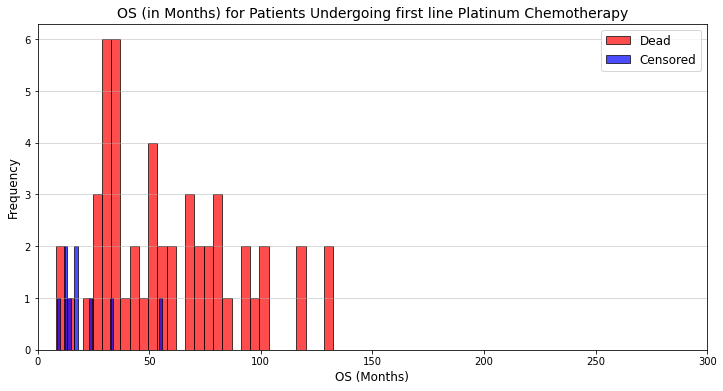

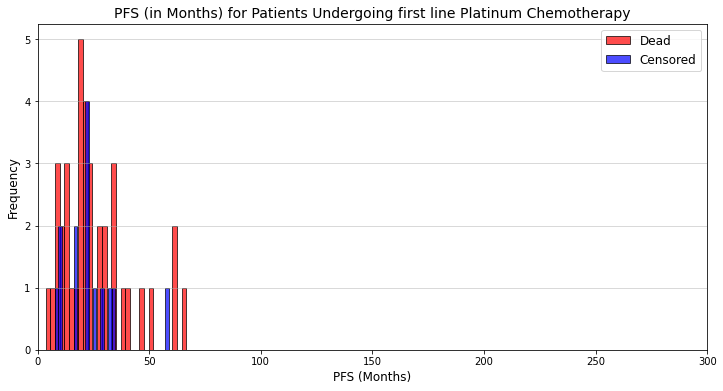

38

In [5]:
# Has surv times values... 
# make plots 
msk = pd.read_csv("/tank/WSI_data/Ovarian_WSIs/MSK-IMPACT/dataframes/clin_df.csv")
msk = msk[msk['Type of surgery'] == 'PDS'] # Note most are neoadjuvent ! why so many?...
msk = msk[msk['Received PARPi'] == False]

# Split data by censoring status (is_dead)
uncencered = msk[msk['observed.OS'] == True]
censored = msk[msk['observed.OS'] == False]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(uncencered['duration.OS'], bins=30, alpha=0.7, label='Dead', color='red', edgecolor='black')
plt.hist(censored['duration.OS'], bins=30, alpha=0.7, label='Censored', color='blue', edgecolor='black')

# Add titles and labels
plt.title('OS (in Months) for Patients Undergoing first line Platinum Chemotherapy', fontsize=14)
plt.xlabel('OS (Months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.6)
plt.xlim(0, 300)  # Set xmax to 300

# Show the plot
plt.show()

# something liek a 6 year split?... 



# Has surv times values... 
# make plots 
msk = pd.read_csv("/tank/WSI_data/Ovarian_WSIs/MSK-IMPACT/dataframes/clin_df.csv")
msk = msk[msk['Type of surgery'] == 'PDS'] # Note most are neoadjuvent ! why so many?...
msk = msk[msk['Received PARPi'] == False]

# Split data by censoring status (is_dead)
uncencered = msk[msk['observed.PFS'] == True]
censored = msk[msk['observed.PFS'] == False]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(uncencered['duration.PFS'], bins=30, alpha=0.7, label='Dead', color='red', edgecolor='black')
plt.hist(censored['duration.PFS'], bins=30, alpha=0.7, label='Censored', color='blue', edgecolor='black')

# Add titles and labels
plt.title('PFS (in Months) for Patients Undergoing first line Platinum Chemotherapy', fontsize=14)
plt.xlabel('PFS (Months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.6)
plt.xlim(0, 300)  # Set xmax to 300

# Show the plot
plt.show()


uncencered['duration.OS'].notna().sum()  # 38 patiets here with survival data....  theres even less with H&E slides! 25!


# TCGA-OV

In [6]:
# there are two sources of labels... for TCGA... double check their definitions to have all the info...

# TODO: check how hese labels are made .... and if its the exact same as CPTAC?....


TCGA_clinial_2 = pd.read_excel("/mnt/ncshare/ozkilim/Ovarian_HRD_pred/OV_RNA/data/Zhang_TCGA_Clinical.xlsx") #from Zhang CPTAC paper. maybe redefine from main clincal....6 months cutoff.... 
# https://www.sciencedirect.com/science/article/pii/S0092867416306730#app2 i think its not mentioned 

TCGA_clinial_2 = TCGA_clinial_2[TCGA_clinial_2['PlatinumStatus'] != "Not available"]
# remove not avalable... 
TCGA_clinial_2['label'] = TCGA_clinial_2['PlatinumStatus'].map({'Sensitive': 1, 'Resistant': 0})
TCGA_clinial_2['label'].value_counts()
TCGA_clinial_2.head()
TCGA_clinial_2 = TCGA_clinial_2[['bcr_patient_barcode','label']]
len(TCGA_clinial_2)




# Load the dataset
file_path = '/mnt/ncshare/ozkilim/BRCA/data/TCGA_metadata/TCGA-CDR-SupplementalTableS1.xlsx' # This is general metadata for TCGA... some extra cases...
clinical_data = pd.read_excel(file_path, sheet_name=0)

# Filter for Type=OV using the correct column name 'type'
ovarian_data = clinical_data[clinical_data['type'] == 'OV']

# Convert columns to appropriate data types if necessary
ovarian_data['PFI.time'] = pd.to_numeric(ovarian_data['PFI.time'], errors='coerce')
ovarian_data['new_tumor_event_dx_days_to'] = pd.to_numeric(ovarian_data['new_tumor_event_dx_days_to'], errors='coerce')




# TODO check there is also a concrete repsonse label! 
# treatment_outcome_first_course # TODO: find the time definition for these... is it 1 year like CPTAC? 

# Filtering from Chowdhury definition..


# Filtering for Refractory Patients
refractory_patients = ovarian_data[
    ((ovarian_data['new_tumor_event_dx_days_to'] <= 180) |
     ((ovarian_data['residual_tumor'] == 'R0') & (ovarian_data['treatment_outcome_first_course'] == 'Radiographically detectable disease after 6 cycles')) |
     ((ovarian_data['residual_tumor'] == 'R1') & (ovarian_data['treatment_outcome_first_course'].isin(['Stable', 'Progressive']))))
]

# Filtering for Sensitive Patients
sensitive_patients = ovarian_data[
    ((ovarian_data['PFI.time'] >= 730))
]
# Check no overlap between the groups!
refractory_patient_ids = refractory_patients['bcr_patient_barcode']
sensitive_patient_ids = sensitive_patients['bcr_patient_barcode']
sensitive_patients_final = sensitive_patients[~sensitive_patients['bcr_patient_barcode'].isin(refractory_patient_ids)]
refractory_patients_final = refractory_patients[~refractory_patients['bcr_patient_barcode'].isin(sensitive_patient_ids)]

sensitive_patients_final['label'] = 1
refractory_patients_final['label'] = 0

# Combine both dataframes into one
TCGA_clinial = pd.concat([sensitive_patients_final[['bcr_patient_barcode', 'label']], 
                               refractory_patients_final[['bcr_patient_barcode', 'label']]])

# Rename columns for clarity
TCGA_clinial.columns = ['bcr_patient_barcode', 'label']

TCGA_clinial['label'].value_counts()



# see how many overlap and how many agree. 

common_df = pd.merge(TCGA_clinial, TCGA_clinial_2, on='bcr_patient_barcode', suffixes=('_1', '_2'))

# Check if the 'label' is the same for these patients in both dataframes
common_df['label_agree'] = common_df['label_1'] == common_df['label_2']

# Calculate statistics
total_common = len(common_df)
agree_count = common_df['label_agree'].sum()
disagree_count = total_common - agree_count

# Print statistics
print(f'Total common bcr_patient_barcode values: {total_common}')
print(f'Number of labels that agree: {agree_count}')
print(f'Number of labels that disagree: {disagree_count}')

#### take label as the one with the 

merged_df = pd.merge(TCGA_clinial, TCGA_clinial_2, on='bcr_patient_barcode', how='outer', suffixes=('_1', '_2'), indicator=True)

# Create the 'label' column
# If 'label_1' exists, use it; if 'label_2' exists and 'label_1' does not, use 'label_2'
merged_df['label'] = merged_df.apply(
    lambda row: row['label_1'] if pd.notna(row['label_1']) else row['label_2'], axis=1
)

# Drop the unnecessary columns and the merge indicator
different_barcodes_df = merged_df.drop(columns=['label_1', 'label_2', '_merge'])


different_barcodes_df.head()
different_barcodes_df['label'].value_counts()

Total common bcr_patient_barcode values: 32
Number of labels that agree: 32
Number of labels that disagree: 0


/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.0    234
0.0     55
Name: label, dtype: int64

# CPTAC_OV


## Qualitative statements for 158 cases...

In [7]:
# This has some pre defined values baed on 1 year -- add metadat file here ....
# Response Evaluation Criteria in Solid Tumors (RECIST):

# Complete Response (CR)
# Definition: Disappearance of all target lesions.
# Key Points:
# There must be no evidence of disease in imaging or clinical evaluation.
# Tumor markers (if relevant) must return to normal levels.
# Stable Disease (SD)
# Definition: Neither sufficient shrinkage to qualify for Partial Response (PR) nor sufficient increase to qualify for Progressive Disease (PD), taking as reference the smallest sum of the longest diameter (LD) recorded since the treatment started.
# Key Points:
# Indicates a lack of significant tumor growth or shrinkage.
# Must persist for a predefined period (e.g., at least 6–8 weeks, depending on the study protocol).
# Progressive Disease (PD)
# Definition: At least a 20% increase in the sum of the LD of target lesions, taking as reference the smallest sum LD recorded since the treatment started. Alternatively, the appearance of one or more new lesions also qualifies as PD.
# Key Points:
# Progression indicates the treatment is not effectively controlling the disease.
# Any unequivocal progression of non-target lesions is also considered PD.
# Partial Response (PR)
# Definition: At least a 30% decrease in the sum of the LD of target lesions, taking as reference the baseline sum LD.
# Key Points:
# Indicates a significant reduction in tumor size.
# All target lesions must shrink to qualify.


#These are all surgery and adjuvant therapies.

CPTAC = pd.read_csv("/mnt/ncshare/ozkilim/Ovarian_HRD_pred/OV_cohort_cleaner/original_cohorts/test_CPTAC.csv")  # Is this from Zhang? and sam as TCGA?....

# FIND where this was downloaded... 

CPTAC['Measure of Success of Outcome at the Completion of Initial First Course Treatment (surgery and adjuvant therapies)'].value_counts()


# TODO: get definitions of each case here from the paper. 



# /mnt/ncshare/ozkilim/Ovarian_HRD_pred/OV_cohort_cleaner/original_cohorts/test_CPTAC.csv #These are all surgery and adjuvant therapies.

# Just i rememebr this being at one year....

Complete Response      99
Stable Disease         26
Progressive Disease    17
Partial Response       16
Name: Measure of Success of Outcome at the Completion of Initial First Course Treatment (surgery and adjuvant therapies), dtype: int64

In [8]:
# Basically we need some way to map OS to response vs no response or some cutoff or splitting some values ... 



# OOI

In [ ]:
# Load cohort, and check how many patients have slides...  clean etc.





# Final plot


The goal is to have a huge heatmaps that is interactive with HRD, BRCA has pr ... 

this is like the master dataframe for all ovarian projects... with all cohorts organized...


1. We need some naming and values standard... 
2. Each df will be WSI based or just clincal? maybe keep them as a join for afterwards... make a new slide_id + case_id df to join later.. 



turn to streamlit app that we can make cohorts from... easiy and quickly! ...   